In [70]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [10]:
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda





Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: E:\anaconda

  added / updated specs:
    - cudatoolkit=10.2
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cudatoolkit-10.2.89        |       h74a9793_1       317.2 MB
    libjpeg-turbo-2.0.0        |       h196d8e1_0         618 KB
    libuv-1.44.2               |       h2bbff1b_0         288 KB
    pytorch-2.3.0              |      py3.9_cpu_0       138.3 MB  pytorch
    pytorch-mutex-1.0          |              cpu           3 KB  pytorch
    torchaudio-2.3.0           |         py39_cpu         5.7 MB  pytorch
    torchvision-0.18.0         |         py39_cpu         6.5 MB  pytorch
    ------------------------------------------------------------
   

In [58]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = []
        self.img_labels = []
        
        for label in ["NORMAL", "PNEUMONIA"]:
            img_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(img_dir):
                self.img_files.append(os.path.join(img_dir, img_file))
                if label == "NORMAL":
                    self.img_labels.append("normal")
                else:
                    if "bacteria" in img_file:
                        self.img_labels.append("bacterie")
                    elif "virus" in img_file:
                        self.img_labels.append("virus")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        label_map = {'normal': 0, 'bacterie': 1, 'virus': 2}
        label = label_map[label]
        return image, label

In [59]:
# Step 2: Visualize the data with diversity
def visualize_data(dataset, num_images=6):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 15))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        ax[i].imshow(img.permute(1, 2, 0))
        label_map = {0: 'normal', 1: 'bacterie', 2: 'virus'}
        ax[i].set_title(label_map[label])
        ax[i].axis('off')
    plt.show()

In [60]:
# Step 3: Resize the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


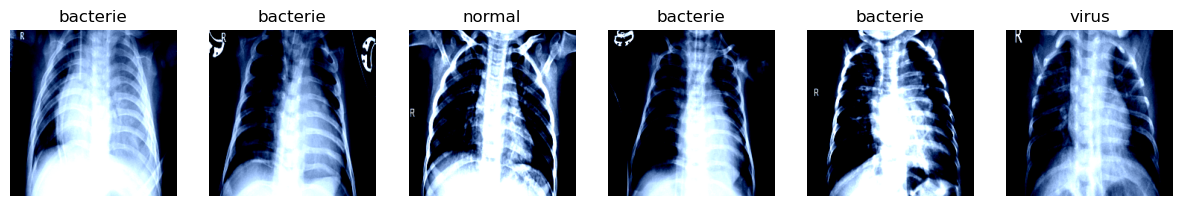

In [61]:
# Initialize dataset
dataset = PneumoniaDataset(root_dir='../data', transform=transform)

# Step 4: Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Visualize some images from the training dataset
visualize_data(train_dataset)

### 1 - Un modèle préentrainé

Resnet18

In [62]:
print("Loading ResNet18 model...")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming we have 3 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the model (optional, for demonstration)
def train_model(model, dataloaders, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f"Batch {i+1}/{len(dataloaders[phase])}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                print(f"Batch {i+1}/{len(dataloaders[phase])} completed")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Create smaller datasets for quick testing
small_train_dataset, small_val_dataset = random_split(train_dataset, [len(train_dataset) // 10, len(train_dataset) - len(train_dataset) // 10])
small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
small_val_loader = DataLoader(small_val_dataset, batch_size=16, shuffle=True)

# Dataloaders for training and validation
dataloaders = {'train': small_train_loader, 'val': small_val_loader}

# Train the model
print("Starting training...")
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=3)
print("Training completed.")

Loading ResNet18 model...
Starting training...
Epoch 0/2
----------
Batch 1/3
Batch 1/3 completed
Batch 2/3
Batch 2/3 completed
Batch 3/3
Batch 3/3 completed
train Loss: 0.8625 Acc: 0.5814
Batch 1/25
Batch 1/25 completed
Batch 2/25
Batch 2/25 completed
Batch 3/25
Batch 3/25 completed
Batch 4/25
Batch 4/25 completed
Batch 5/25
Batch 5/25 completed
Batch 6/25
Batch 6/25 completed
Batch 7/25
Batch 7/25 completed
Batch 8/25
Batch 8/25 completed
Batch 9/25
Batch 9/25 completed
Batch 10/25
Batch 10/25 completed
Batch 11/25
Batch 11/25 completed
Batch 12/25
Batch 12/25 completed
Batch 13/25
Batch 13/25 completed
Batch 14/25
Batch 14/25 completed
Batch 15/25
Batch 15/25 completed
Batch 16/25
Batch 16/25 completed
Batch 17/25
Batch 17/25 completed
Batch 18/25
Batch 18/25 completed
Batch 19/25
Batch 19/25 completed
Batch 20/25
Batch 20/25 completed
Batch 21/25
Batch 21/25 completed
Batch 22/25
Batch 22/25 completed
Batch 23/25
Batch 23/25 completed
Batch 24/25
Batch 24/25 completed
Batch 25/25
B

Logistic regression (sklearn)

E:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 1.0
Validation Accuracy: 0.8723404255319149
Test Accuracy: 0.8829787234042553

Classification Report (Test):
               precision    recall  f1-score   support

      Normal       0.95      0.90      0.92        41
    Bacterie       0.89      0.93      0.91        42
       Virus       0.64      0.64      0.64        11

    accuracy                           0.88        94
   macro avg       0.82      0.82      0.82        94
weighted avg       0.88      0.88      0.88        94



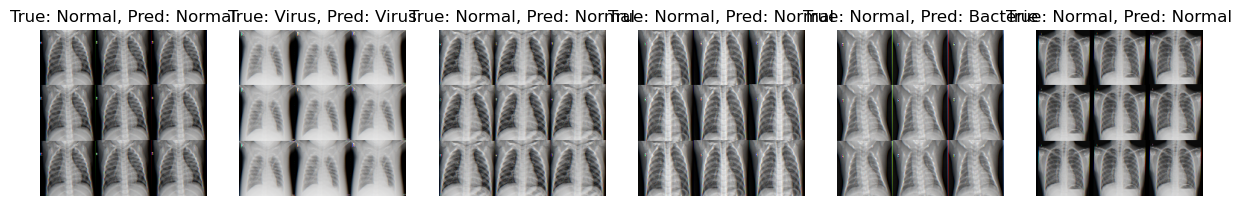

In [69]:
# Step 1: Load and transform the data
class PneumoniaDatasetSklearn:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_files = []
        self.img_labels = []
        
        for label in ["NORMAL", "PNEUMONIA"]:
            img_dir = os.path.join(root_dir, label)
            for img_file in os.listdir(img_dir):
                self.img_files.append(os.path.join(img_dir, img_file))
                if label == "NORMAL":
                    self.img_labels.append(0)
                else:
                    if "bacteria" in img_file:
                        self.img_labels.append(1)
                    elif "virus" in img_file:
                        self.img_labels.append(2)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return np.array(image).flatten(), label

# Step 2: Transform and prepare the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
dataset = PneumoniaDatasetSklearn(root_dir='../data', transform=transform)

# Prepare data for scikit-learn
X, y = [], []
for i in range(len(dataset)):
    img, label = dataset[i]
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred_train = log_reg.predict(X_train)
y_pred_val = log_reg.predict(X_val)
y_pred_test = log_reg.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test, target_names=['Normal', 'Bacterie', 'Virus']))

# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, num_images=6):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 15))
    indices = np.random.choice(len(X), num_images, replace=False)
    for i, idx in enumerate(indices):
        img = X[idx].reshape(224, 224, 3)
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        ax[i].imshow(img)
        ax[i].set_title(f"True: {['Normal', 'Bacterie', 'Virus'][true_label]}, Pred: {['Normal', 'Bacterie', 'Virus'][pred_label]}")
        ax[i].axis('off')
    plt.show()

# Visualize predictions on test data
visualize_predictions(X_test, y_test, y_pred_test)